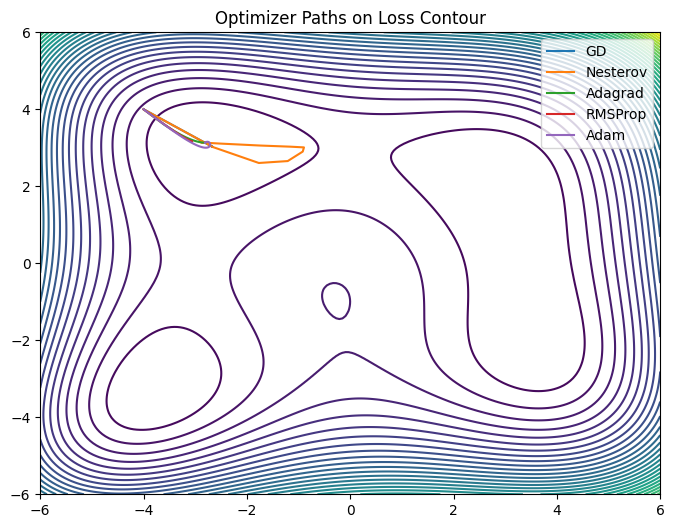

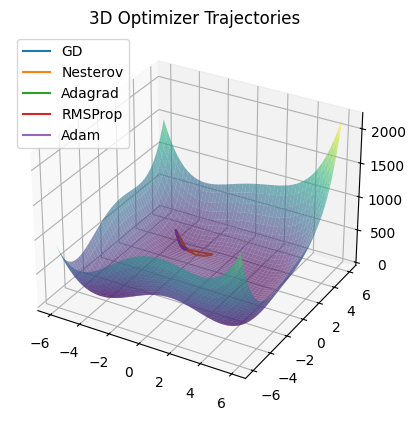

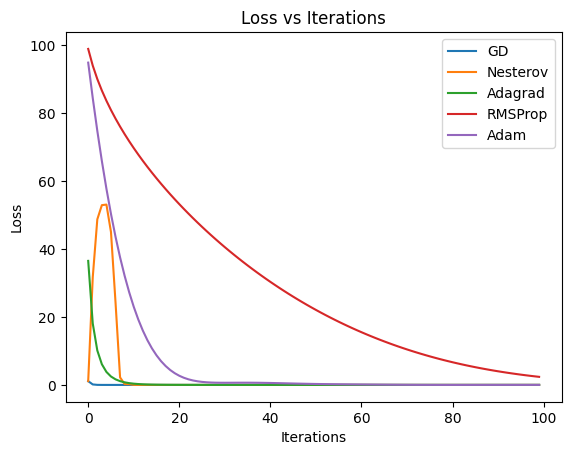

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 23s 2us/step


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import tensorflow as tf
from sklearn.preprocessing import StandardScaler


# Himmelblau Function
def J(w):
    w1, w2 = w
    return (w1**2 + w2 - 11)**2 + (w1 + w2**2 - 7)**2


def grad_J(w):
    w1, w2 = w
    dw1 = 4*w1*(w1**2 + w2 - 11) + 2*(w1 + w2**2 - 7)
    dw2 = 2*(w1**2 + w2 - 11) + 4*w2*(w1 + w2**2 - 7)
    return np.array([dw1, dw2])


# Gradient Descent
def GD(init, lr=0.01, steps=100):
    w = init.copy()
    path = [w.copy()]
    loss = []

    for _ in range(steps):
        w -= lr * grad_J(w)
        path.append(w.copy())
        loss.append(J(w))

    return np.array(path), loss


# Nesterov
def Nesterov(init, lr=0.01, gamma=0.9, steps=100):
    w = init.copy()
    v = np.zeros_like(w)
    path = [w.copy()]
    loss = []

    for _ in range(steps):
        lookahead = w - gamma * v
        g = grad_J(lookahead)
        v = gamma * v + lr * g
        w -= v
        path.append(w.copy())
        loss.append(J(w))

    return np.array(path), loss


# Adagrad
def Adagrad(init, lr=0.4, steps=100):
    w = init.copy()
    G = np.zeros_like(w)
    eps = 1e-8
    path = [w.copy()]
    loss = []

    for _ in range(steps):
        g = grad_J(w)
        G += g**2
        w -= lr * g / (np.sqrt(G) + eps)
        path.append(w.copy())
        loss.append(J(w))

    return np.array(path), loss


# RMSProp
def RMSProp(init, lr=0.01, beta=0.9, steps=100):
    w = init.copy()
    Eg = np.zeros_like(w)
    eps = 1e-8
    path = [w.copy()]
    loss = []

    for _ in range(steps):
        g = grad_J(w)
        Eg = beta * Eg + (1 - beta) * (g**2)
        w -= lr * g / (np.sqrt(Eg) + eps)
        path.append(w.copy())
        loss.append(J(w))

    return np.array(path), loss


# Adam
def Adam(init, lr=0.05, steps=100):
    w = init.copy()
    m = np.zeros_like(w)
    v = np.zeros_like(w)
    b1, b2 = 0.9, 0.999
    eps = 1e-8
    path = [w.copy()]
    loss = []

    for t in range(1, steps + 1):
        g = grad_J(w)
        m = b1 * m + (1 - b1) * g
        v = b2 * v + (1 - b2) * (g**2)
        mhat = m / (1 - b1**t)
        vhat = v / (1 - b2**t)
        w -= lr * mhat / (np.sqrt(vhat) + eps)
        path.append(w.copy())
        loss.append(J(w))

    return np.array(path), loss


# Initial point
init = np.array([-4.0, 4.0])

optimizers = {
    "GD": GD,
    "Nesterov": Nesterov,
    "Adagrad": Adagrad,
    "RMSProp": RMSProp,
    "Adam": Adam
}

paths = {}
losses = {}

for name, opt in optimizers.items():
    paths[name], losses[name] = opt(init)


# Contour Plot
x = np.linspace(-6, 6, 200)
y = np.linspace(-6, 6, 200)
X, Y = np.meshgrid(x, y)
Z = J([X, Y])

plt.figure(figsize=(8, 6))
plt.contour(X, Y, Z, 40)

for name, p in paths.items():
    plt.plot(p[:, 0], p[:, 1], label=name)

plt.legend()
plt.title("Optimizer Paths on Loss Contour")
plt.show()


# 3D Surface Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap=cm.viridis, alpha=0.6)

for name, p in paths.items():
    z = [J(w) for w in p]
    ax.plot(p[:, 0], p[:, 1], z, label=name)

ax.set_title("3D Optimizer Trajectories")
plt.legend()
plt.show()


# Loss Curves
plt.figure()
for name, l in losses.items():
    plt.plot(l, label=name)

plt.legend()
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Loss vs Iterations")
plt.show()


# MNIST Logistic Regression (0 vs 1)
(x_train, y_train), _ = tf.keras.datasets.mnist.load_data()

mask = (y_train == 0) | (y_train == 1)
x = x_train[mask]
y = y_train[mask]

x = x.reshape(len(x), -1)

f1 = x[:, :392].mean(axis=1)
f2 = x[:, 392:].mean(axis=1)

X = np.vstack((f1, f2)).T
X = StandardScaler().fit_transform(X)
y = y.astype(np.float32)


def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def loss_lr(w):
    p = sigmoid(X.dot(w))
    return -np.mean(y*np.log(p + 1e-8) + (1-y)*np.log(1-p + 1e-8))


def grad_lr(w):
    p = sigmoid(X.dot(w))
    return X.T.dot(p - y) / len(y)


def train_adam_lr(steps=200, lr=0.05):
    w = np.zeros(2)
    m = np.zeros(2)
    v = np.zeros(2)
    b1, b2 = 0.9, 0.999
    eps = 1e-8
    path = [w.copy()]
    losses = []

    for t in range(1, steps + 1):
        g = grad_lr(w)
        m = b1*m + (1-b1)*g
        v = b2*v + (1-b2)*(g**2)
        mhat = m/(1-b1**t)
        vhat = v/(1-b2**t)
        w -= lr*mhat/(np.sqrt(vhat)+eps)
        path.append(w.copy())
        losses.append(loss_lr(w))

    return np.array(path), losses


path_lr, loss_lr_vals = train_adam_lr()